<br><p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold">
DSE 200X Final Project <br> <br> <br>Olympic Predictions</p><br><br>

# Step 1:  Find a dataset or datasets

After searching through datasets at https://www.kaggle.com/datasets, I came across the Olympic History dataset:
* [120 years of Olympic history: athletes and results](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results)

# Step 2:  Explore the dataset(s)
In this step, I was expected to explore what is present in the data and how the data is organized. I was advised to answer the following questions:
* Are there quality issues in the dataset (noisy, missing data, etc.)?
* What will you need to do to clean and/or transform the raw data for analysis?

## Setup
To run the following cells, the "athlete_events.csv" file must be downloaded and saved to the same directory as this notebook. Perform the following steps to complete this setup.
1. Navigate to: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results
2. Sign in to Kaggle or create a new account.
3. Download the dataset and unzip the "archive.zip" folder.
4. Move the "athlete_events.csv" file to the same directory as this notebook.

## Data Exploration and Cleaning

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
%matplotlib inline
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_csv('athlete_events.csv', sep=',')
print("Athlete events shape: ", data.shape, "\nAthlete events type: ", type(data))
original_rows = data.shape[0] # Reference for the initial number of rows.
data.head()

Athlete events shape:  (271116, 15) 
Athlete events type:  <class 'pandas.core.frame.DataFrame'>


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


### Quality Issue 1: NaN or No Medal Earned?
After observing the "Medal" column in the above cell, I noted that there was a large number of NaN values. As specified on the Kaggle webpage for this dataset, the "Medal" column consists of the following values: Gold, Silver, Bronze, or NA.

I wanted to change all NaN values to "None", to indicate that these athletes did not win a medal in the event. However, I was concerned that *not all NaN values equated to athletes who did not win a medal*. According to an article from olympic.org, a silver medal was awarded to the winner of the first modern era Olympic Games in Athens in 1896. Additionally, the 1904 Olympic Games in St Louis were the first to award gold, silver, and bronze medals to the first, second, and third place winners [2]. 
> In order to minimize the number of inappropriate changes from NaN to "None" in the "Medal" column, I removed all rows from the dataset covering **events for which no medals were earned**.

In [3]:
# Create a dictionary with olympic events as keys and the number of medals awarded in
#    each event as values.
event_medal_counts = {}
for index, row in data.iterrows():
    event_key = row['Games'] +'|'+ row['Event'] +'|'+ row['City']
    if event_key not in event_medal_counts:
        event_medal_counts[event_key] = 0
    medal_awarded = row['Medal']
    if medal_awarded == 'Gold' or medal_awarded == 'Silver' or medal_awarded == 'Bronze':
        event_medal_counts[event_key] += 1

# Show 10 of the dictionary's key value pairs.
list(event_medal_counts.items())[:10]

[("1992 Summer|Basketball Men's Basketball|Barcelona", 36),
 ("2012 Summer|Judo Men's Extra-Lightweight|London", 4),
 ("1920 Summer|Football Men's Football|Antwerpen", 46),
 ("1900 Summer|Tug-Of-War Men's Tug-Of-War|Paris", 12),
 ("1988 Winter|Speed Skating Women's 500 metres|Calgary", 3),
 ("1988 Winter|Speed Skating Women's 1,000 metres|Calgary", 3),
 ("1992 Winter|Speed Skating Women's 500 metres|Albertville", 3),
 ("1992 Winter|Speed Skating Women's 1,000 metres|Albertville", 3),
 ("1994 Winter|Speed Skating Women's 500 metres|Lillehammer", 3),
 ("1994 Winter|Speed Skating Women's 1,000 metres|Lillehammer", 3)]

In [4]:
# Save the keys for non-medal olympic events to a set.
non_medal_keys = set()
for key, value in event_medal_counts.items():
    if value == 0:
        non_medal_keys.add(key)
non_medal_keys

{"1900 Summer|Archery Men's Unknown Event|Paris",
 '1920 Summer|Sailing Mixed 18 foot|Antwerpen',
 "1920 Summer|Shooting Men's Unknown Event|Antwerpen",
 '1924 Summer|Art Competitions Mixed Music|Paris',
 '1928 Summer|Art Competitions Mixed Music, Compositions For Solo Or Chorus|Amsterdam',
 '1928 Summer|Art Competitions Mixed Music, Instrumental And Chamber|Amsterdam',
 "1928 Winter|Speed Skating Men's 10,000 metres|Sankt Moritz",
 '1932 Summer|Art Competitions Mixed Architecture, Unknown Event|Los Angeles',
 '1932 Summer|Art Competitions Mixed Painting, Unknown Event|Los Angeles',
 '1932 Summer|Art Competitions Mixed Sculpturing, Unknown Event|Los Angeles',
 '1932 Summer|Art Competitions Mixed Unknown Event|Los Angeles',
 "1932 Summer|Equestrianism Men's Jumping, Team|Los Angeles",
 '1936 Summer|Art Competitions Mixed Architecture, Unknown Event|Berlin',
 '1936 Summer|Art Competitions Mixed Literature, Unknown Event|Berlin',
 '1936 Summer|Art Competitions Mixed Music, Instrumental An

In [5]:
print('Dropping all rows associated with non-medal events:')
before_rows = data.shape[0]
# Drop all rows associated with non-medal events.
for event_key in non_medal_keys:
    games, event, city = event_key.split('|')
    games_mask = data['Games'] == games
    event_mask = data['Event'] == event
    city_mask = data['City'] == city
    data.drop(data[games_mask & event_mask & city_mask].index, inplace = True)
after_rows = data.shape[0]

percentage_dropped = ((before_rows - after_rows)/ original_rows)*100
total_percentage_dropped = ((before_rows - after_rows)/ original_rows)*100
print('\tNo. rows dropped for non-medal events: ', before_rows - after_rows,
      '\n\tPercentage of original rows dropped: ', percentage_dropped, '%',
      '\n\tTotal Percentage of original rows dropped: ', total_percentage_dropped, '%')

Dropping all rows associated with non-medal events:
	No. rows dropped for non-medal events:  1819 
	Percentage of original rows dropped:  0.6709305242036618 % 
	Total Percentage of original rows dropped:  0.6709305242036618 %


In [6]:
# Change all instances of NaN in the Medal column to 'None'.
data['Medal'] = data['Medal'].fillna('None')
data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None


### Quality Issue 2: Remaining NaN Values
Although I removed all NaN values from the "Medal" column, I suspected that there was still a number of NaN values present in the dataset. In the following few cells, I explored the dataset to gain a better understanding of the presence of these missing values.

In [7]:
# Create a mask to identify all rows with 1 or more null or NaN values.
null_mask = data.isnull().any(axis=1)
# Create a mask to identify all rows without null or NaN values.
no_null_mask = null_mask.apply(lambda x: False if x else True)

# Print the number of unique athletes with missing or complete info.
null_id_set = set(data[null_mask]['ID'].unique())
print('No. of Athletes with missing info: ', len(null_id_set))
no_null_id_set = set(data[no_null_mask]['ID'].unique())
print('No. of Athletes with complete info: ', len(no_null_id_set))

print('\nNumber of rows with null values: ', data[null_mask].shape[0],
      '\nMin year with null values: ', data[null_mask]['Year'].min(),
      '\nMax year with null values: ', data[null_mask]['Year'].max())

No. of Athletes with missing info:  35684
No. of Athletes with complete info:  99084

Number of rows with null values:  63150 
Min year with null values:  1896 
Max year with null values:  2016


Year Counts:
	Shape:  (35, 2) 
	Min Year:  1896 
	Max Year:  2016
Null Year Counts:
	Shape:  (35, 2) 
	Min Year:  1896 
	Max Year:  2016


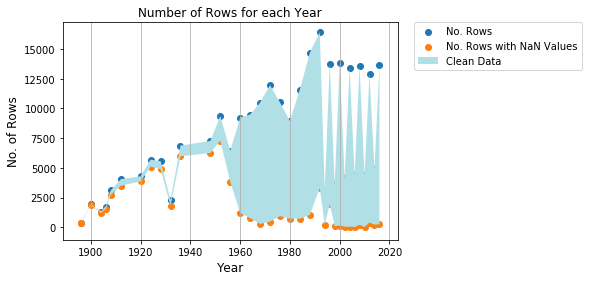

In [8]:
# Count the number of rows for each year.
year_counts = data[['ID', 'Year']].groupby('Year', as_index=False).count()
year_counts.columns = ['Year', 'Row Count']

# Count the number of rows containing NaN values for each year.
null_year_counts = data[null_mask][['ID', 'Year']].groupby('Year', as_index=False).count()
null_year_counts.columns = ['Year', 'Null Row Count']

# Verify that both year counts have the same temporal range.
print('Year Counts:\n\tShape: ', year_counts.shape,
      '\n\tMin Year: ', year_counts['Year'].min(),
      '\n\tMax Year: ', year_counts['Year'].max())
print('Null Year Counts:\n\tShape: ', null_year_counts.shape,
      '\n\tMin Year: ', null_year_counts['Year'].min(),
      '\n\tMax Year: ', null_year_counts['Year'].max())

years = year_counts['Year'].values
row_counts = year_counts['Row Count'].values
null_row_counts = null_year_counts['Null Row Count'].values

# Plot row counts and null row counts over the years. Includes approximate non-null row
#     count (or "clean data") in shaded region.
plt.scatter(years, row_counts, label = 'No. Rows')
plt.scatter(years, null_row_counts, label = 'No. Rows with NaN Values')
plt.fill_between(years, row_counts, null_row_counts, facecolor = 'powderblue', label = 'Clean Data')
plt.grid(axis = 'x')
plt.xlabel('Year', fontsize = 12)
plt.ylabel('No. of Rows', fontsize = 12)
plt.title('Number of Rows for each Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

NaN values seem to be most present in the years prior to 1960. Dropping all rows containing NaN values would mean dropping the majority of rows from this time period. I decided to **drop all rows covering years prior to 1960**, as the amount of rows from this period would be scarce compared to the rest of the dataset **after dropping all NaN rows**.

In [9]:
print('Dropping all rows containing NaN Values:')
before_rows = data.shape[0]
data = data.dropna()
after_rows = data.shape[0]

percentage_dropped = ((before_rows - after_rows)/ original_rows)*100
total_percentage_dropped += percentage_dropped
print('\tNo. of rows dropped with NaN values: ', before_rows - after_rows,
      '\n\tPercentage of original rows dropped: ', percentage_dropped, '%',
      '\n\tTotal Percentage of original rows dropped: ', total_percentage_dropped, '%')

Dropping all rows containing NaN Values:
	No. of rows dropped with NaN values:  63150 
	Percentage of original rows dropped:  23.292612756163415 % 
	Total Percentage of original rows dropped:  23.963543280367077 %


In [10]:
print('Dropping all rows covering years prior to 1960:')
before_rows = data.shape[0]
data.drop(data[data['Year'] < 1960].index, inplace = True)
after_rows = data.shape[0]

percentage_dropped = ((before_rows - after_rows)/ original_rows)*100
total_percentage_dropped += percentage_dropped
print('\tNo. of rows prior to 1960 dropped: ', before_rows - after_rows,
      '\n\tPercentage of original rows dropped: ', percentage_dropped, '%',
      '\n\tTotal Percentage of original rows dropped: ', total_percentage_dropped, '%')

Dropping all rows covering years prior to 1960:
	No. of rows prior to 1960 dropped:  10063 
	Percentage of original rows dropped:  3.7116953628705054 % 
	Total Percentage of original rows dropped:  27.67523864323758 %


### Transformation Issue 1: Only Individual Events
Events for the olympic games can be for individuals or teams. Upon review of the "sports" section of the olympic.org website, individual events award one gold medal to the top winner, while team events award gold medals to each member of the winning team [[3](https://www.olympic.org/sports)].

For this classification problem, I wanted to work exclusively with data from individual events. In order to separate rows for individual events from those for team events, I identified all events for which multiple gold medals were awarded as "team_events". *I assumed that each unique event occured only once in a year*.

In [11]:
# Generate a list of all unique events.
events = data['Event'].unique().tolist()
single_events = copy.deepcopy(events)
team_events = []
# Generate separate lists for individual and team events.
for event in events:
    event_mask = data['Event'] == event
    gold_mask = data['Medal'] == 'Gold'
    # Stage holding all years for which a gold medal was awarded in "event".
    event_gold_stage = data[event_mask & gold_mask]['Year']
    # Only team events are expected to have duplicate years for which a gold medal was awarded.
    if event_gold_stage.values.shape[0] != event_gold_stage.unique().shape[0]:
        single_events.remove(event)
        team_events.append(event)
print('No. of Unique Events: ', len(events),
      '\nNo. of Unique Single Events: ', len(single_events),
      '\nNo. of Unique Team Events: ', len(team_events))

No. of Unique Events:  489 
No. of Unique Single Events:  342 
No. of Unique Team Events:  147


In [12]:
# Create a mask to specify which rows belong to team events.
team_event_mask = data['Event'] == team_events[0]
for event in team_events:
    event_mask = data['Event'] == event
    team_event_mask = team_event_mask | event_mask

In [13]:
print('Dropping all rows associated with team events:')
before_rows = data.shape[0]
data.drop(data[team_event_mask].index, inplace = True)
after_rows = data.shape[0]

percentage_dropped = ((before_rows - after_rows)/ original_rows)*100
total_percentage_dropped += percentage_dropped
print('\tNo. of rows associated with team events dropped: ', before_rows - after_rows,
      '\n\tPercentage of original rows dropped: ', percentage_dropped, '%',
      '\n\tTotal Percentage of original rows dropped: ', total_percentage_dropped, '%')

Dropping all rows associated with team events:
	No. of rows associated with team events dropped:  84870 
	Percentage of original rows dropped:  31.303943699375914 % 
	Total Percentage of original rows dropped:  58.9791823426135 %


In [14]:
sports = data['Sport'].unique().tolist()
print(' ---------------------------------------',
      '\n| No. of Unique Individual Sports: ', len(sports), ' |',
      '\n ---------------------------------------',
      '\n\nSport: No. Rows',
      '\n__________________')
for sport in sports:
    print(sport, ': ', data[data['Sport'] == sport].shape[0])

 --------------------------------------- 
| No. of Unique Individual Sports:  37  | 
 --------------------------------------- 

Sport: No. Rows 
__________________
Judo :  3366
Speed Skating :  4126
Cross Country Skiing :  5569
Badminton :  555
Sailing :  1346
Biathlon :  3286
Athletics :  23039
Alpine Skiing :  5663
Weightlifting :  2852
Wrestling :  4962
Luge :  835
Swimming :  11953
Equestrianism :  2295
Shooting :  7030
Gymnastics :  6266
Taekwondo :  596
Boxing :  4241
Fencing :  3047
Diving :  1631
Cycling :  5184
Rowing :  519
Figure Skating :  633
Archery :  1243
Modern Pentathlon :  804
Table Tennis :  965
Nordic Combined :  742
Freestyle Skiing :  913
Canoeing :  1877
Rhythmic Gymnastics :  250
Trampolining :  149
Triathlon :  526
Tennis :  994
Golf :  108
Snowboarding :  924
Ski Jumping :  1534
Skeleton :  173
Short Track Speed Skating :  1018


## Feature Selection and Engineering
With the data cleaned and transformed, it was time to begin feature selection. For this project, I wanted to use the Decision Tree Classifier available from the scikit-learn library. From the original features available, I chose to use the following for the classification model.
* **Numeric**:
    * Age
    * Height
    * Weight
* **Categorical**:
    * Sex
    * Season
    * Medal
    
In addition to the provided features, I wanted to append derived features to the dataset. The following acronyms were used to shorten the derived feature names:
* Individual Event Medals (IEM)
* Individual Sport Medals (ISM)
* Opponent Event Medals (OEM)
* Opponent Sport Medals (OSM)

The names and descriptions of the derived numeric features are as follows:
* **Olympic_Years**: The number of years since the athlete first appeared in the olympics.
* **IEM**: The number of medals the athlete won in the current event.
* **IEM_Bronze**: The number of bronze medals the athlete won in the current event.
* **IEM_Silver**: The number of silver medals the athlete won in the current event.
* **IEM_Gold**: The number of gold medals the athlete won in the current event.
* **ISM**: The number of medals the athlete won in the current sport.
* **ISM_Bronze**: The number of bronze medals the athlete won in the current sport.
* **ISM_Silver**: The number of silver medals the athlete won in the current sport.
* **ISM_Gold**: The number of gold medals the athlete won in the current sport.
* **Opponents**: The number of opponents the athlete is competing against.
* **OEM**: The number of medals won by all collective opponents in the current event.
* **OEM_Bronze**: The number of bronze medals won by all collective opponents in the current event.
* **OEM_Silver**: The number of silver medals won by all collective opponents in the current event.
* **OEM_Gold**: The number of gold medals won by all collective opponents in the current event.
* **OSM**: The number of medals won by all collective opponents in the current sport.
* **OSM_Bronze**: The number of bronze medals won by all collective opponents in the current sport.
* **OSM_Silver**: The number of silver medals won by all collective opponents in the current sport.
* **OSM_Gold**: The number of gold medals won by all collective opponents in the current sport.

### Categorical to "Dummy" Features
The Decision Tree Classifier from scikit-learn cannot take categorical features as direct input, so I needed to convert those features to dummy variables using one-hot encoding.

In [15]:
sex_one_hot = pd.get_dummies(data['Sex'])
season_one_hot = pd.get_dummies(data['Season'])
medal_one_hot = pd.get_dummies(data['Medal'])

data = data.join(sex_one_hot).drop('Sex', axis = 1)
data = data.join(season_one_hot).drop('Season', axis = 1)
data = data.join(medal_one_hot).drop('Medal', axis = 1)

data.head()

,ID,Name,Age,Height,Weight,Team,NOC,Games,Year,City,Sport,Event,F,M,Summer,Winter,Bronze,Gold,None,Silver
1,2,A Lamusi,23.0,170.0,60.0,China,CHN,2012 Summer,2012,London,Judo,Judo Men's Extra-Lightweight,0,1,1,0,0,0,1,0
4,5,Christine Jacoba Aaftink,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Calgary,Speed Skating,Speed Skating Women's 500 metres,1,0,0,1,0,0,1,0
5,5,Christine Jacoba Aaftink,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",1,0,0,1,0,0,1,0
6,5,Christine Jacoba Aaftink,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Albertville,Speed Skating,Speed Skating Women's 500 metres,1,0,0,1,0,0,1,0
7,5,Christine Jacoba Aaftink,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",1,0,0,1,0,0,1,0


### Replace the 'None' with 'Medal_Earned' Column
Replacing the 'None' column with 'Medal_Earned' is a convenient way of getting the target feature for classification.

In [16]:
data['Medal_Earned'] = data['None'].apply(lambda x: 0 if x == 1 else 1)
del data['None']
data.head()

,ID,Name,Age,Height,Weight,Team,NOC,Games,Year,City,Sport,Event,F,M,Summer,Winter,Bronze,Gold,Silver,Medal_Earned
1,2,A Lamusi,23.0,170.0,60.0,China,CHN,2012 Summer,2012,London,Judo,Judo Men's Extra-Lightweight,0,1,1,0,0,0,0,0
4,5,Christine Jacoba Aaftink,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Calgary,Speed Skating,Speed Skating Women's 500 metres,1,0,0,1,0,0,0,0
5,5,Christine Jacoba Aaftink,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",1,0,0,1,0,0,0,0
6,5,Christine Jacoba Aaftink,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Albertville,Speed Skating,Speed Skating Women's 500 metres,1,0,0,1,0,0,0,0
7,5,Christine Jacoba Aaftink,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",1,0,0,1,0,0,0,0


### (Optional) Load the Cleaned Olympic Events Dataset
Instead of running the above cells (*except the first one to import libraries*) to generate the dataset, the same dataset is available to be read from the 'cleaned_olympics.csv' file for convenience.

In [17]:
# Save the contents of the 'data' Data Frame to the 'cleaned_olympics.csv' file.
# data.to_csv('cleaned_olympics.csv', index = False)

# Load the contents from 'cleaned_olympics.csv' to the 'data' Data Frame.
# data = pd.read_csv('cleaned_olympics.csv', sep=',')

### Limitation: One Sport At A Time
Due to the high **computational cost** required to generate the derived numeric features, I decided to limit the model to perform on one "Sport" at a time. Breaking down that process by each sport allows for time in-between computations. Additionally, it allows for assessment of the derived features' feasibility prior to generating them for the entire dataset.

Because the input data for the model is being limited to one sport at a time, the 'Summer' and 'Winter' features are no longer required, as no olympic sport is hosted during both seasons.

In [18]:
sport_name = 'Diving'
ml_data = data[data['Sport'] == sport_name].copy()
# Remove columns that won't be used for the classification
del ml_data['Name']
del ml_data['Team']
del ml_data['NOC']
del ml_data['Games']
del ml_data['City']
del ml_data['Sport']
del ml_data['Summer']
del ml_data['Winter']
ml_data.head()

,ID,Age,Height,Weight,Year,Event,F,M,Bronze,Gold,Silver,Medal_Earned
168,70,26.0,167.0,65.0,2000,Diving Men's Platform,0,1,0,0,0,0
317,170,18.0,172.0,61.0,2016,Diving Women's Platform,1,0,0,0,0,0
682,395,16.0,160.0,62.0,2008,Diving Women's Springboard,1,0,0,0,0,0
683,395,20.0,160.0,62.0,2012,Diving Women's Springboard,1,0,0,0,0,0
685,395,24.0,160.0,62.0,2016,Diving Women's Springboard,1,0,0,0,0,0


### Adding the Derived Features
The derived features that will be added below were based on my own general knowledge. Consequently, only a fraction of them will be generated for the purpose of testing their efficacy in producing accurate predictions.

In [19]:
def addNumericFeatures(df, num_rows):
# Input:
#     df [Pandas.DataFrame]: Data Frame containing all original features and rows.
#     num_rows [Int]: Number of rows in df.
# Output:
#     df [Pandas.DataFrame]: Data Frame containing all original and derived features.
    print('Rows to compute: ', num_rows) # Computation of 100 rows: ~48 seconds
    df['Olympic_Years'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['IEM'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['IEM_Bronze'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['IEM_Silver'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['IEM_Gold'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['ISM'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['ISM_Bronze'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['ISM_Silver'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['ISM_Gold'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['Opponents'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['OEM'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['OEM_Bronze'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['OEM_Silver'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['OEM_Gold'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['OSM'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['OSM_Bronze'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['OSM_Silver'] = pd.DataFrame(np.zeros((num_rows, 1)))
    df['OSM_Gold'] = pd.DataFrame(np.zeros((num_rows, 1)))
    
    for index, row in df.iterrows():
        athlete_id = row['ID']
        year = row['Year']
        event = row['Event']
        
        id_mask = df['ID'] == athlete_id
        year_mask = df['Year'] < year
        same_yr_mask = df['Year'] == year
        event_mask = df['Event'] == event
        competitors_mask = same_yr_mask & event_mask
        bronze_mask = df['Bronze'] == 1
        silver_mask = df['Silver'] == 1
        gold_mask = df['Gold'] == 1
        
        olympic_years = year - df[id_mask]['Year'].min()
        iem_bronze = df[id_mask & year_mask & event_mask & bronze_mask].shape[0]
        iem_silver = df[id_mask & year_mask & event_mask & silver_mask].shape[0]
        iem_gold = df[id_mask & year_mask & event_mask & gold_mask].shape[0]
        ism_bronze = df[id_mask & year_mask & bronze_mask].shape[0]
        ism_silver = df[id_mask & year_mask & silver_mask].shape[0]
        ism_gold = df[id_mask & year_mask & gold_mask].shape[0]
        iem = iem_bronze + iem_silver + iem_gold
        ism = ism_bronze + ism_silver + ism_gold
        
        opponents = df[competitors_mask].shape[0] - 1
        opponent_ids = df[competitors_mask]['ID'].values.tolist()
        opponent_ids.remove(athlete_id)
        oem_bronze = 0
        oem_silver = 0
        oem_gold = 0
        osm_bronze = 0
        osm_silver = 0
        osm_gold = 0
        for opponent_id in opponent_ids:
            opponent_id_mask = df['ID'] == opponent_id
            oem_bronze += df[opponent_id_mask & year_mask & event_mask & bronze_mask].shape[0]
            oem_silver += df[opponent_id_mask & year_mask & event_mask & silver_mask].shape[0]
            oem_gold += df[opponent_id_mask & year_mask & event_mask & gold_mask].shape[0]
            osm_bronze += df[opponent_id_mask & year_mask & bronze_mask].shape[0]
            osm_silver += df[opponent_id_mask & year_mask & silver_mask].shape[0]
            osm_gold += df[opponent_id_mask & year_mask & gold_mask].shape[0]
        oem = oem_bronze + oem_silver + oem_gold
        osm = osm_bronze + osm_silver + osm_gold
     
        # Add Olympic_Years value
        df.at[index, 'Olympic_Years'] = olympic_years
        # Add IEM values
        df.at[index, 'IEM'] = iem
        df.at[index, 'IEM_Bronze'] = iem_bronze
        df.at[index, 'IEM_Silver'] = iem_silver
        df.at[index, 'IEM_Gold'] = iem_gold
        # Add ISM values
        df.at[index, 'ISM'] = ism
        df.at[index, 'ISM_Bronze'] = ism_bronze
        df.at[index, 'ISM_Silver'] = ism_silver
        df.at[index, 'ISM_Gold'] = ism_gold
        # Add Opponents value
        df.at[index, 'Opponents'] = opponents
        # Add OEM values
        df.at[index, 'OEM'] = oem
        df.at[index, 'OEM_Bronze'] = oem_bronze
        df.at[index, 'OEM_Silver'] = oem_silver
        df.at[index, 'OEM_Gold'] = oem_gold
        # Add OSM values
        df.at[index, 'OSM'] = osm
        df.at[index, 'OSM_Bronze'] = osm_bronze
        df.at[index, 'OSM_Silver'] = osm_silver
        df.at[index, 'OSM_Gold'] = osm_gold
    return df

In [20]:
# Generate the numeric features
ml_data = addNumericFeatures(ml_data, ml_data.shape[0])

# Save generated features to a csv file.
# ml_data.to_csv('diving_features.csv', index = False)

# Read data from CSV file. Available CSVs:
#     boxing_features.csv
#     cycling_features.csv
#     diving_features.csv
#     equestrianism_features.csv
#     gymnastics_features.csv
#     weightlifting_features.csv
#     wrestling_features.csv

# sport_name = 'Diving'
# ml_data = pd.read_csv('diving_features.csv', sep=',')

Rows to compute:  1631


In [21]:
ml_data.head()

,ID,Age,Height,Weight,Year,Event,F,M,Bronze,Gold,...,ISM_Gold,Opponents,OEM,OEM_Bronze,OEM_Silver,OEM_Gold,OSM,OSM_Bronze,OSM_Silver,OSM_Gold
168,70,26.0,167.0,65.0,2000,Diving Men's Platform,0,1,0,0,...,0.0,41.0,2.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0
317,170,18.0,172.0,61.0,2016,Diving Women's Platform,1,0,0,0,...,0.0,27.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
682,395,16.0,160.0,62.0,2008,Diving Women's Springboard,1,0,0,0,...,0.0,29.0,4.0,1.0,2.0,1.0,5.0,1.0,2.0,2.0
683,395,20.0,160.0,62.0,2012,Diving Women's Springboard,1,0,0,0,...,0.0,29.0,2.0,1.0,1.0,0.0,3.0,1.0,2.0,0.0
685,395,24.0,160.0,62.0,2016,Diving Women's Springboard,1,0,0,0,...,0.0,28.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### Preparing Feature Sets
The final step in feature selection was to prepare unique combinations of features to compare against each other. Although it would be simplest to test the classification model using all available features together, the objective of this project is to determine **which features are most effective in making accurate predictions**. 

The "getAllCombinations" function was written to facilitate generating feature combinations.

In [22]:
def getAllCombinations(elem_list):
    # Input: [list] List containing features as elements. Elements can be strings or
    #        tuples containing strings.
    # Output: [list] List containing tuples of feature combinations. Tuples contain only
    #         strings.
    comb_results = []
    n = len(elem_list)
    for r in range(1, n+1):
        comb_tuples = combinations(elem_list, r)
        for tuple_elem in comb_tuples:
            # Check for and reformat nested tuples.
            if type(tuple_elem[0]) == type(tuple()):
                single_tuple = tuple()
                for i in range(len(tuple_elem)):
                    single_tuple += tuple_elem[i]
                comb_results.append(single_tuple)
            else:
                comb_results.append(tuple_elem)
    return comb_results

In [23]:
feature_tuples = []

numeric_features = ['Age', 'Height', 'Weight', 'Olympic_Years', 'Opponents']
numeric_feature_tuples = getAllCombinations(numeric_features)
feature_tuples += numeric_feature_tuples

feature_tuples_extension_1 = []

sex_feature_tuple = ('F', 'M')
for ft in feature_tuples:
    feature_tuples_extension_1.append(ft + sex_feature_tuple)
feature_tuples += feature_tuples_extension_1

feature_tuples_extension_1 = []
feature_tuples_extension_2 = []

derived_features_1 = ['IEM', 'ISM', 'OEM', 'OSM']
derived_feature_tuples_1 = getAllCombinations(derived_features_1)
for ft_derived_1 in derived_feature_tuples_1:
    for ft in feature_tuples:
        feature_tuples_extension_1.append(ft + ft_derived_1)

derived_features_2 = [('IEM_Bronze', 'IEM_Silver', 'IEM_Gold'),
                      ('ISM_Bronze', 'ISM_Silver', 'ISM_Gold'),
                      ('OEM_Bronze', 'OEM_Silver', 'OEM_Gold'),
                      ('OSM_Bronze', 'OSM_Silver', 'OSM_Gold')]
derived_feature_tuples_2 = getAllCombinations(derived_features_2)
for ft_derived_2 in derived_feature_tuples_2:
    for ft in feature_tuples:
        feature_tuples_extension_2.append(ft + ft_derived_2)      

feature_tuples += feature_tuples_extension_1
feature_tuples += feature_tuples_extension_2

## Medal Predictions with Classification
With all of the feature sets prepared, it was time to perform and evaluate the medal predictions. In order to gain a comprehensive understanding of the performance for each feature set, I ran 'N' classification 

In [24]:
M = len(feature_tuples) # Number of feature tuples
N = 50 # Number of tests.
accuracy_matrix = np.zeros((M,N))
target_feature = 'Medal_Earned'
y = ml_data[[target_feature]]
for n in range(N):
    for m in range(M):
        X = ml_data[list(feature_tuples[m])]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=n+731)
        medal_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0) # Decision Tree Classifier object
        medal_classifier.fit(X_train, y_train)
        predictions = medal_classifier.predict(X_test)
        accuracy_matrix[m,n] = accuracy_score(y_true = y_test, y_pred = predictions)

### Calculate the Average Accuracy Score for each Feature Set

In [25]:
accuracy_averages = np.zeros(M)
for m in range(M):
    accuracy_averages[m] = np.average(accuracy_matrix[m])
print('Accuracy Score Info: ', sport_name, '\n', accuracy_averages)
max_accuracy_average = max(accuracy_averages)
print('Min: ', min(accuracy_averages),
      '\nMax: ', max_accuracy_average,
      '\nAverage: ', np.average(accuracy_averages), 
      '\nFeature Set with Highest Average Accuracy Score:\n', 
      feature_tuples[np.argmax(accuracy_averages)])

Accuracy Score Info:  Diving 
 [0.8904441  0.89084227 0.89068913 ... 0.89601838 0.89500766 0.89519142]
Min:  0.8823583460949465 
Max:  0.8985911179173048 
Average:  0.8924412740047137 
Feature Set with Highest Average Accuracy Score:
 ('Age', 'Olympic_Years', 'F', 'M', 'IEM_Bronze', 'IEM_Silver', 'IEM_Gold', 'ISM_Bronze', 'ISM_Silver', 'ISM_Gold')


### Show the Most Frequently Used Features Among the Top t Performing Feature Sets

In [26]:
# Get the indices for the top t accuracy scores, corresponding to the top performing feature sets.
T = 250
best_feature_indices = np.argsort(-accuracy_averages)[:T]
top_feature_dict = dict()

for t in range(T):
    accuracy_average_t = accuracy_averages[best_feature_indices[t]]
    for feature in feature_tuples[best_feature_indices[t]]:
        if feature not in top_feature_dict:
            top_feature_dict[feature] = 1
        else:
            top_feature_dict[feature] += 1
print(top_feature_dict)

{'Age': 182, 'Olympic_Years': 146, 'F': 121, 'M': 121, 'IEM_Bronze': 143, 'IEM_Silver': 143, 'IEM_Gold': 143, 'ISM_Bronze': 178, 'ISM_Silver': 178, 'ISM_Gold': 178, 'Opponents': 157, 'OEM_Bronze': 103, 'OEM_Silver': 103, 'OEM_Gold': 103, 'OSM_Bronze': 74, 'OSM_Silver': 74, 'OSM_Gold': 74, 'Height': 54, 'Weight': 93, 'ISM': 6, 'OEM': 5, 'IEM': 1, 'OSM': 2}


In [27]:
for feature in sex_feature_tuple:
    if feature in top_feature_dict:
        new_feature = 'Sex'
        if new_feature not in top_feature_dict:
            top_feature_dict[new_feature] = top_feature_dict[feature]
        del top_feature_dict[feature]

for feature_tuple in derived_features_2:
    for feature in feature_tuple:
        if feature in top_feature_dict:
            new_feature = feature[:4] + 'Specific'
            if new_feature not in top_feature_dict:
                top_feature_dict[new_feature] = top_feature_dict[feature]
            del top_feature_dict[feature]
top_feature_dict = dict(sorted(top_feature_dict.items(), key=lambda item: item[1], reverse = True))

In [28]:
# Show Top T Average Accuracy Scores
accuracy_averages[best_feature_indices]

array([0.89859112, 0.89856049, 0.89852986, 0.89846861, 0.89846861,
       0.89843798, 0.89840735, 0.89837672, 0.89828484, 0.89822358,
       0.89819296, 0.89816233, 0.89816233, 0.8981317 , 0.89810107,
       0.89807044, 0.89800919, 0.89794793, 0.8979173 , 0.8979173 ,
       0.89788668, 0.89788668, 0.89788668, 0.89785605, 0.89785605,
       0.89779479, 0.89779479, 0.89776417, 0.89776417, 0.89773354,
       0.89770291, 0.89767228, 0.89764165, 0.89761103, 0.89761103,
       0.89761103, 0.89754977, 0.89751914, 0.89748851, 0.89745789,
       0.89745789, 0.89742726, 0.89742726, 0.89742726, 0.89742726,
       0.89739663, 0.89739663, 0.89739663, 0.89739663, 0.897366  ,
       0.897366  , 0.89733538, 0.89733538, 0.89733538, 0.89733538,
       0.89730475, 0.89730475, 0.89727412, 0.89727412, 0.89727412,
       0.89727412, 0.89727412, 0.89727412, 0.89727412, 0.89724349,
       0.89724349, 0.89724349, 0.89721286, 0.89721286, 0.89721286,
       0.89721286, 0.89718224, 0.89718224, 0.89718224, 0.89715

([<matplotlib.axis.XTick at 0x7faee4117a10>,
 <a list of 14 Text xticklabel objects>)

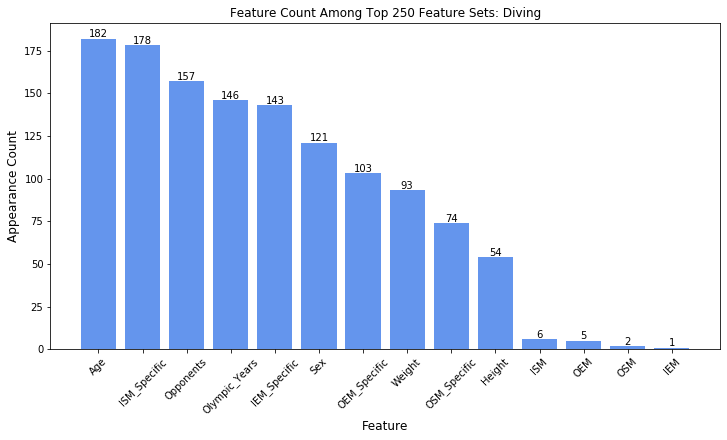

In [30]:
X = np.arange(len(top_feature_dict))
Y = list(top_feature_dict.values())
Y = [round(num, 1) for num in Y]
labels = list(top_feature_dict.keys())

fig, ax = plt.subplots(figsize = (12,6))
plt.bar(X, Y, width = 0.8, color = 'cornflowerblue')
for i, v in enumerate(Y):
    ax.text(i, v+0.8, str(v), horizontalalignment='center')
ax.set_xlabel('Feature', fontsize = 12)
ax.set_ylabel('Appearance Count', fontsize = 12)
ax.set_title('Feature Count Among Top ' + str(T) + ' Feature Sets: ' + sport_name, fontsize = 12)
plt.xticks(X, labels, rotation = 45)

# Step 3:  Identify 1-3 research questions
Now that you have a better understanding of the data, you will want to form a research question which is interesting to you. The research question should be broad enough to be of interest to a reader but narrow enough that the question can be answered with the data.  Some examples:
* **Too Narrow:**  *What is the GDP of the U.S. for 2011?*  This is just asking for a fact or a single data point.  
* **Too Broad:**  *What is the primary reason for global poverty?*  This could be a Ph.D. thesis and would still be way too broad.  What data will you use to answer this question?  Even if a single dataset offered an answer, would it be defendable given the variety of datasets out there?
* **Good (just right):**  *Can you use sentiment analysis on comments about movies on Twitter to predict its box office earnings?*  If you have, or can obtain, tweets which refer to a variety of movies and you have their box office earnings, this is a question which you can potentially answer well.

**My research question:**
Which features are most important in predicting if an athlete will win a medal using a decision tree classifier?

# Step 4:  Describe your dataset(s) and your research question(s) at the end of Week 9 in the Project. 

**Checkpoint:** Be sure to report your progress so far at the Week 9 Checkpoint Engagement.

# Step 5:  Identify your research methods
Based on your research question, you can now describe how you will go about answering that question.  Your methods will depend on the question being asked.  For example, if you are looking for a relationship between two items (say, CO2 emissions and GDP), you may wish to use scatter plots and statistical correlation.  If you are trying to predict an outcome based on input data, you’ll need to identify the appropriate methods from the week on Machine Learning.  Be sure to document, in your notebook, your research methods.

# Step 6:  Present your findings
In this step, you can begin to report your findings.  What did you learn from the data and how do your findings help answer your research question?  Use visualizations to present these findings.

# Step 7:  Identify limitations to your conclusions
Rarely will a single data analysis conclusively answer a research question.  Here, you need to identify possible limitations.  For example, are your results limited to a certain area, city, or country?  Are you making assumptions about the data which may, or may not, be valid (e.g., that students in one term are equally qualified as students in another)?  Document these limitations.

# Step 8:  (Optional) Identify future work
You may have clear next steps at the end of your analysis.  For example, you may wish to perform the same analysis in another setting or you think your findings lead to new questions.  Feel free to document these next steps.

# Step 9: Present your work!
Fill in this slide template to present your project (*hyperlink was here*).  Feel free to add more slides, but aim to keep your entire presentation **below 20 total slides**.  We also recommend you attach a PDF of your Jupyter notebook to this presentation in one single PDF file to be uploaded. As you are writing, please follow the guidelines below:
## General Guidelines for Project Reports and Presentations:
1. This is academic writing. Keep it formal and coherent as a self-contained entity. Anyone reading your presentation should have a full understanding of the question, approach and the results.


2. Be professional. You should be comfortable giving this presentation to the general public, your boss, or your academic advisor.


3. Write for a diverse audience including:

    1. **General Public:** Reads only the title and abstract looking for high-level point mainly for conversational purposes.

    2. **A company CEO:** Reads introduction, research question, findings and conclusions looking for business value and details related to that.

    3. **An academic advisor (or company CTO):** Reads the full presentation AND your Jupyter Notebook paying particular attention to technical coherence, academic value, and technical data science strengths.

The final presentation should also be for the above-mentioned three audiences. Think of the diversity of the audience. The whole point is to **tell a story** - so you should motivate a reader to care based on the question you are exploring, answer that question in a clear and concise manner, provide an honest appraisal of your results, and give the reader valuable insights.  Use charts whenever possible. Avoid slides with a lot of text and bullet points - break the slide into multiple slides when this happens.  Be concise!

# References
1. The Kaggle website source. [Here](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results).
2. The source on the history of olympic medals. [Here](https://www.olympic.org/olympic-medals).
3. The source on gold medals awarded for different events. [Here](https://www.olympic.org/sports)